In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import pi
from matplotlib import rc
plt.style.reload_library()
plt.style.use(['science', 'grid'])
from scipy.odr import ODR, Model, Data, RealData
import scipy.optimize as opt; #allows for curve fitting
from scipy.odr import *

In [42]:
# DEFINING FITTING FUNCTIONS
def Interference_double(parameters, x): # [a, d, lambda]
    beta = (pi*parameters[1]/parameters[2])*np.sin(x)
    alpha = (pi*parameters[0]/parameters[2])*np.sin(x)
    return (np.cos(beta)**2)*(np.sin(alpha)/alpha)**2

def Interference_double2(parameters, x): # [lambda]
    beta = (pi*0.4431e-3/parameters[0])*np.sin(x)
    alpha = (pi*0.0828e-3/parameters[0])*np.sin(x)
    return (np.cos(beta)**2)*(np.sin(alpha)/alpha)**2

def Interference_single(parameters,x): # [a]
    alpha = (pi*parameters[0]/(656e-9))*np.sin(x)
    return (np.sin(alpha)/alpha)**2

def PlotODR(xdata,ydata,error_x,error_y,function,output,color,x_label,y_label,low_limit, up_limit):
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.errorbar(xdata,ydata,yerr=error_y,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.errorbar(xdata,ydata,xerr=error_x,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    
    title = r'$\textbf{' + y_label + ' vs ' + x_label + '}$'
    x = np.linspace(low_limit, up_limit, 500)
    plt.plot(x,function(output.beta, x),color=color)
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.savefig("Figures/figure.png")

def arctanfunc(x):
    return np.arctan(x)[0]

# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

# DEFINING A FUNCTION THAT RETURNS THE WEIGHTED AVERAGE WITH UNCERTAINTY
def weighted_avgs(values, deltas):
    weights = np.array(list(map(lambda x : 1/x**2, deltas)))
    best_val = np.dot(np.array(values), weights)/weights.sum()
    uncert = 1/np.sqrt(weights.sum())
    return [best_val, uncert]

## Double Slit

In [27]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1iYbA_X-BAgKxj-p5xsn6TMuqubb39IdXJCk7EbgtABg'
workSheetName = 'Week2_Double_Slit'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :7]
df['Error theta'] = df.apply(lambda x: uncertainty_var([x['Position (mm)']/500], [x['Uncert_Position (mm)']/500], arctanfunc), axis=1)
df

,Counts,Uncert_Count,Position (mm),Position - offset (mm),Uncert_Position (mm),Normalized Counts,Theta (rad),Error theta
0,1249,35.341194,5.75,1.55,0.01,0.100995,0.0031,0.00002
1,1298,36.027767,5.70,1.50,0.01,0.104957,0.0030,0.00002
2,1433,37.854986,4.50,0.30,0.01,0.115873,0.0006,0.00002
3,1449,38.065733,2.05,-2.15,0.01,0.117167,-0.0043,0.00002
4,1511,38.871583,5.10,0.90,0.01,0.122180,0.0018,0.00002
...,...,...,...,...,...,...,...,...
77,10592,102.917443,4.80,0.60,0.01,0.856473,0.0012,0.00002
78,11017,104.961898,4.10,-0.10,0.01,0.890839,-0.0002,0.00002
79,11100,105.356538,3.55,-0.65,0.01,0.897550,-0.0013,0.00002
80,11585,107.633638,4.25,0.05,0.01,0.936767,0.0001,0.00002


lambda = ( 548.3419633606538  ±  2.680960857546493 ) nm
Percentage error:  0.6132042863585019 %
Experimental precision: 0.48892133680879346 %
Sigmas: 1.2541982527514703


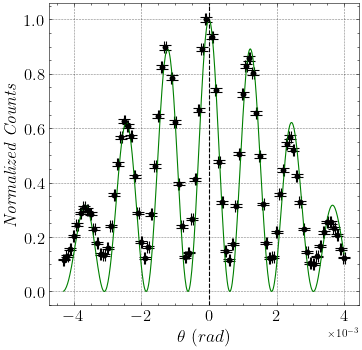

In [43]:
# Adjusting the origin
#df['Normalized Counts'] = df['Normalized Counts'] - df['Normalized Counts'].min()
model = Model(Interference_double2)
xdata, ydata, error_x, error_y = df['Theta (rad)'], df['Normalized Counts'], df['Error theta'], df['Uncert_Count']/(df['Counts'].max())
x_min, x_max = df['Theta (rad)'].min(), df['Theta (rad)'].max()
data = RealData(xdata, ydata, error_x, error_y)
odr = ODR(data, model, [545e-9])
odr.set_job(fit_type=2) #Ordinary least squeares
output = odr.run()
lamb, dlamb = output.beta[0]*1e9, output.sd_beta[0]*1e9
PlotODR(xdata, ydata, error_x, error_y, Interference_double2, output,'green',r'$\theta \ (rad)$', 'Normalized Counts',x_min, x_max)
lamb_nominal = 545 #nm
print('lambda = (', lamb, ' ± ', dlamb, ') nm')

# DETERMING THE %ERROR
error = abs((lamb-lamb_nominal)/lamb_nominal)*100
print("Percentage error: ", error, "%")
exp_precision = 100*dlamb/lamb
print('Experimental precision:', exp_precision, '%')
print('Sigmas:', error/exp_precision)

# Wave-like interference

In [34]:
# Time of flight
path_length = 500e-3 #m
velocity = 3e8 #m
time_flight = path_length/velocity
print('Time of flight = ', time_flight, ' sec')

Time of flight =  1.6666666666666667e-09  sec


In [36]:
# Time between photons
max_count = 12344.6 # Maximum count rate (Photons x second)
time_photons = 1/max_count
print('Time between photons = ', time_photons, ' sec')

Time between photons =  8.100708001879364e-05  sec


In [41]:
# Fraction of time
frac = 100*time_flight/time_photons
print('Fraction = ', frac, '%')

Fraction =  0.0020574333333333336 %
